# Librerias

In [2]:
# Librerías estándar de Python y manipulación de datos
import os
import numpy as np
import pandas as pd
from collections import Counter
import shutil

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.models import Model, Sequential  # Asegurarse de tener Sequential
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.applications import (
    EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception, MobileNetV3Small, EfficientNetB6
)

# Asegurarse de tener modelos preentrenados disponibles
from tensorflow.keras.applications import VGG16, VGG19  # Otras opciones de redes preentrenadas

# Machine Learning y métricas de rendimiento
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV  # GridSearchCV para buscar hiperparámetros

# PyTorch (si es necesario para alguna parte del proyecto)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Weights and Biases (WandB) para monitorizar los experimentos
import wandb
from wandb.integration.keras import WandbCallback

# Manejo de logs y control de depuración
import logging
logging.basicConfig(level=logging.INFO)  # Para depuración y seguimiento del proceso

# Clasificación Multiclase 

## Modelo EfficientNetB0

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB0-dataBalanceada')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar y configurar el modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


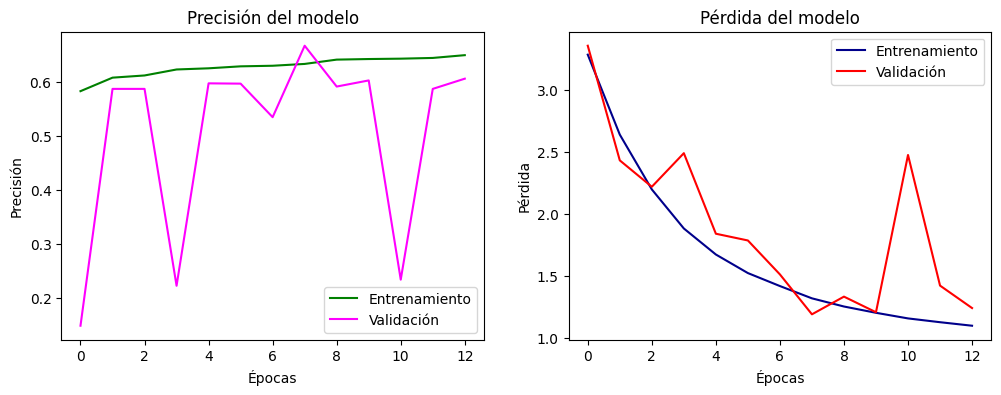

In [ ]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()


# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo EfficientNetB4

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB4-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


NameError: name 'history' is not defined

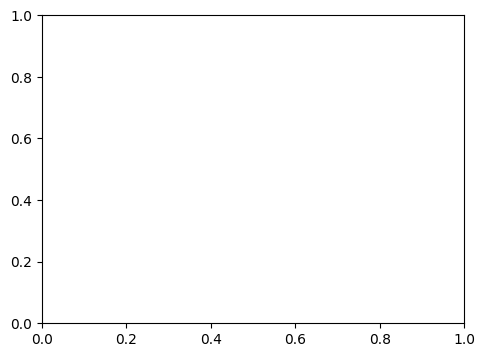

In [7]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo EfficientNetB5

In [2]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='EfficientNetB5')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


NameError: name 'history' is not defined

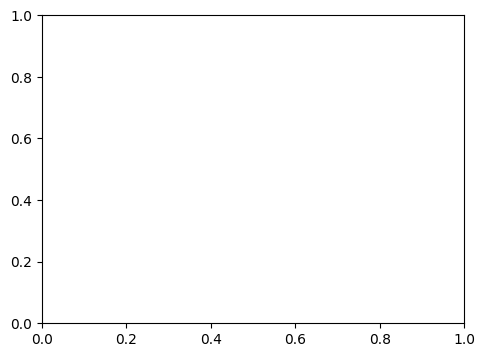

In [8]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo MobileNetV2

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV2')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


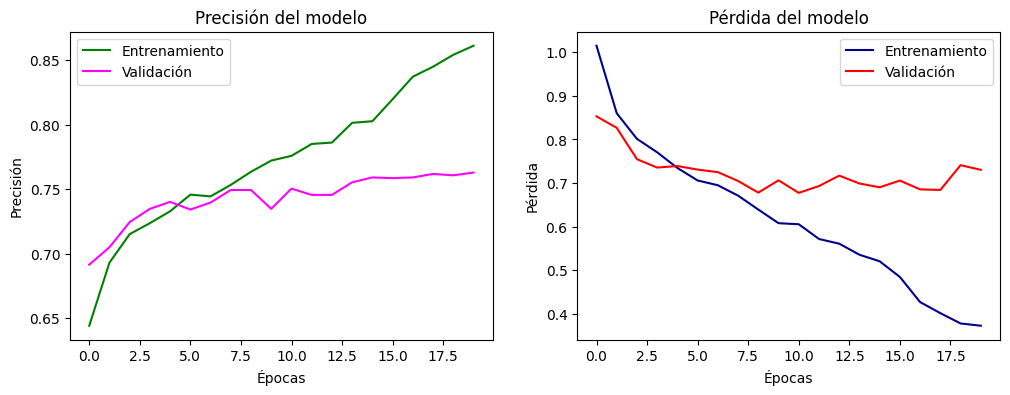

In [144]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo MobileNetV3

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

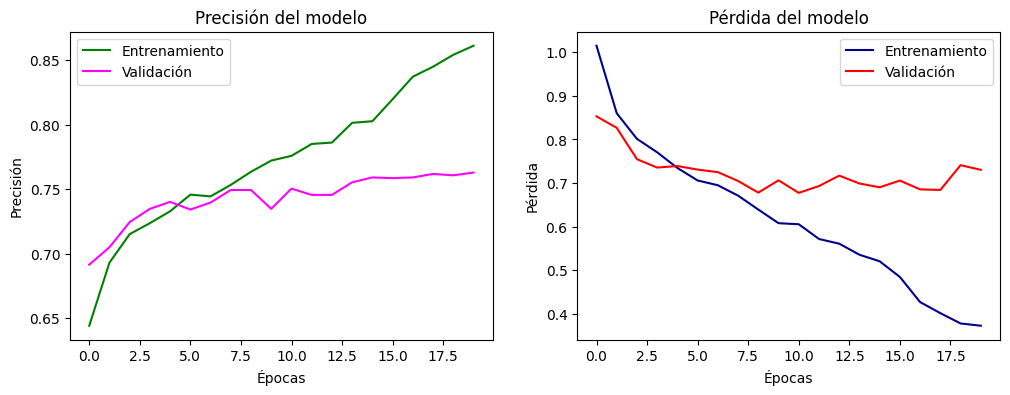

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo InceptionV3

In [8]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='InceptionV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # InceptionV3 requiere imágenes de 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_inception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


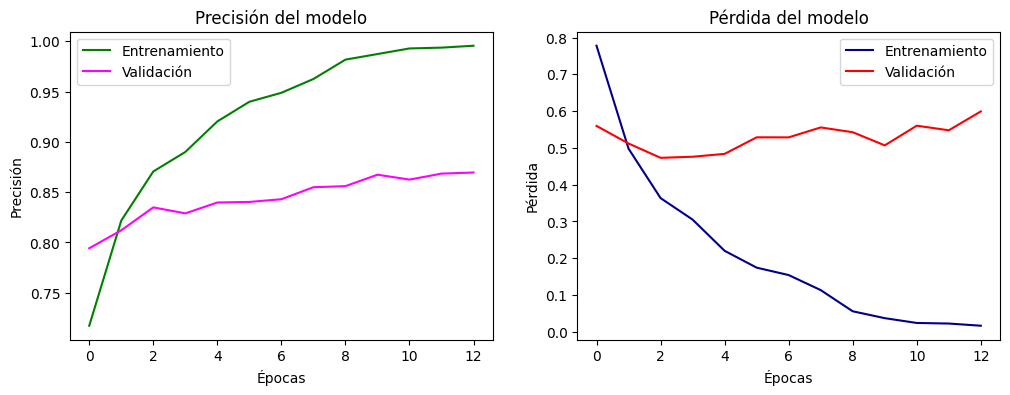

In [6]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo Xception

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import wandb
from wandb.integration.keras import WandbCallback

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision_value = self.precision.result()
        recall_value = self.recall.result()
        return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='Xception-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # Xception también requiere 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Importar y Definir el Modelo Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo con las métricas adicionales
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       F1Score()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_xception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"F1-Score en el conjunto de prueba: {test_f1:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 
           'test_accuracy': test_acc,
           'test_precision': test_precision,
           'test_recall': test_recall,
           'test_f1': test_f1})

wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


Epoch 1/20
254/254 [==============================] - ETA: 0s - loss: 0.9125 - accuracy: 0.6674 - precision: 0.8241 - recall: 0.5213 - f1_score: 0.6386

/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 0.64981, saving model to best_model_xception.h5
254/254 [==============================] - 774s 3s/step - loss: 0.9125 - accuracy: 0.6674 - precision: 0.8241 - recall: 0.5213 - f1_score: 0.6386 - val_loss: 0.6498 - val_accuracy: 0.7596 - val_precision: 0.8455 - val_recall: 0.6578 - val_f1_score: 0.7400 - lr: 1.0000e-04
Epoch 2/20


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.7830 - precision: 0.8580 - recall: 0.7073 - f1_score: 0.7754
Epoch 2: val_loss improved from 0.64981 to 0.56866, saving model to best_model_xception.h5
254/254 [==============================] - 781s 3s/step - loss: 0.5839 - accuracy: 0.7830 - precision: 0.8580 - recall: 0.7073 - f1_score: 0.7754 - val_loss: 0.5687 - val_accuracy: 0.7861 - val_precision: 0.8453 - val_recall: 0.7250 - val_f1_score: 0.7805 - lr: 1.0000e-04
Epoch 3/20
254/254 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.8423 - precision: 0.8849 - recall: 0.7921 - f1_score: 0.8360
Epoch 3: val_loss improved from 0.56866 to 0.53031, saving model to best_model_xception.h5
254/254 [==============================] - 766s 3s/step - loss: 0.4355 - accuracy: 0.8423 - precision: 0.8849 - recall: 0.7921 - f1_score: 0.8360 - val_loss: 0.5303 - val_accuracy: 0.8078 - val_precision: 0.8508 - val_recall: 0.7748 - val_f1_score: 0.8

accuracy,▁▄▅▆▆▇▇▇█████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
f1_score,▁▄▅▆▆▇▇██████
loss,█▅▄▃▃▂▂▂▁▁▁▁▁
lr,████████▁▁▁▁▁
precision,▁▂▄▅▆▆▇▇█████
recall,▁▄▅▆▇▇▇██████
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁


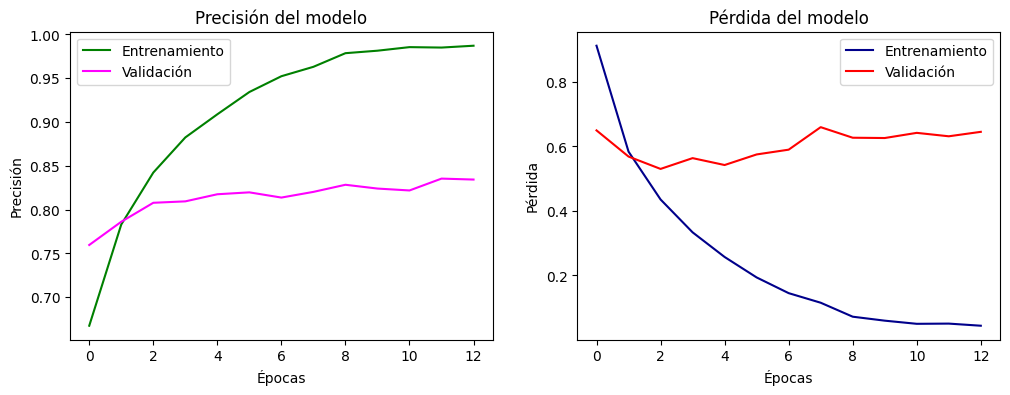

73/73 [==============================] - 122s 2s/step
              precision    recall  f1-score   support

       ASC-H       0.12      0.06      0.08       185
      ASC-US       0.15      0.11      0.13       122
        HSIL       0.30      0.18      0.22       341
        LSIL       0.18      0.11      0.13       272
    Negative       0.65      0.82      0.72      1356
         SCC       0.09      0.06      0.07        33

    accuracy                           0.53      2309
   macro avg       0.25      0.22      0.23      2309
weighted avg       0.46      0.53      0.49      2309



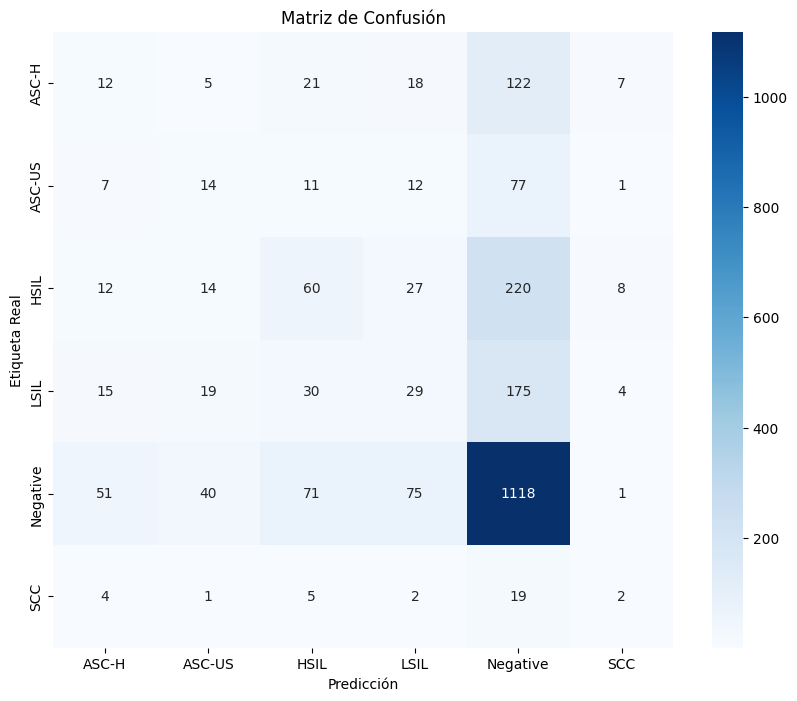

In [5]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Accuracy del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Clasificación Binaria -> clasificación luego multiclase

## Clasificación 2 Clases

### generación de datos

In [5]:
# Directorio de las imágenes
data_dir = 'crops_90x90'

# Directorios de salida para las imágenes
output_dir = 'crops_90x90_2clases'  # Directorio base para las nuevas carpetas
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Crear las carpetas si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Subcarpetas adicionales para "lesion" y "no lesion"
lesion_subfolders = ['1_lesion', '0_no_lesion']
for subfolder in lesion_subfolders:
    os.makedirs(os.path.join(train_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subfolder), exist_ok=True)

# Configuración del generador de imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar todas las imágenes y etiquetas
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical',  # Multiclase inicialmente
    classes=['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC'],
    shuffle=False
)

# Obtener los nombres de archivos y etiquetas
filepaths = all_images_generator.filepaths
labels = all_images_generator.classes

# Convertir las etiquetas multiclase en binarias basado en el índice de 'Negative'
negative_index = all_images_generator.class_indices['Negative']
has_lesion = np.where(labels == negative_index, 0, 1)  # 0: Negative (sin lesión), 1: Otras clases (con lesión)

# Función para generar un dataframe desde los archivos seleccionados con una columna adicional "has_lesion"
def create_dataframe_with_lesion(files, labels, has_lesion_str):
    df = pd.DataFrame({'filename': files, 'label': labels, 'has_lesion': has_lesion_str})
    return df

# Dividir en entrenamiento (70%), validación (15%) y prueba (15%)
train_files, test_files, train_labels, test_labels, train_lesion, test_lesion = train_test_split(
    filepaths, labels, has_lesion.astype(str), test_size=0.30, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels, val_lesion, test_lesion = train_test_split(
    test_files, test_labels, test_lesion, test_size=0.5, stratify=test_labels, random_state=42
)

# Función para copiar imágenes a las carpetas correspondientes
def copy_images(filepaths, lesions, dest_dir):
    for filepath, lesion in zip(filepaths, lesions):
        if lesion == '0':  # Sin lesión (Negative)
            dest_subfolder = '0_no_lesion'
        else:  # Con lesión (todas las demás clases)
            dest_subfolder = '1_lesion'
        
        # Obtener el nombre de la subcarpeta (lesion/no lesion)
        dest_path = os.path.join(dest_dir, dest_subfolder)
        shutil.copy(filepath, dest_path)  # Copiar la imagen

# Copiar imágenes a las carpetas correspondientes en función de si tienen lesión o no
copy_images(train_files, train_lesion, train_dir)
copy_images(val_files, val_lesion, val_dir)
copy_images(test_files, test_lesion, test_dir)

# Imprimir el resultado
print(f"Total de imágenes copiadas a entrenamiento: {len(train_files)}")
print(f"Total de imágenes copiadas a validación: {len(val_files)}")
print(f"Total de imágenes copiadas a prueba: {len(test_files)}")

Found 11534 images belonging to 6 classes.
Total de imágenes copiadas a entrenamiento: 8073
Total de imágenes copiadas a validación: 1730
Total de imágenes copiadas a prueba: 1731


#### Grafico de la distribución de las clases

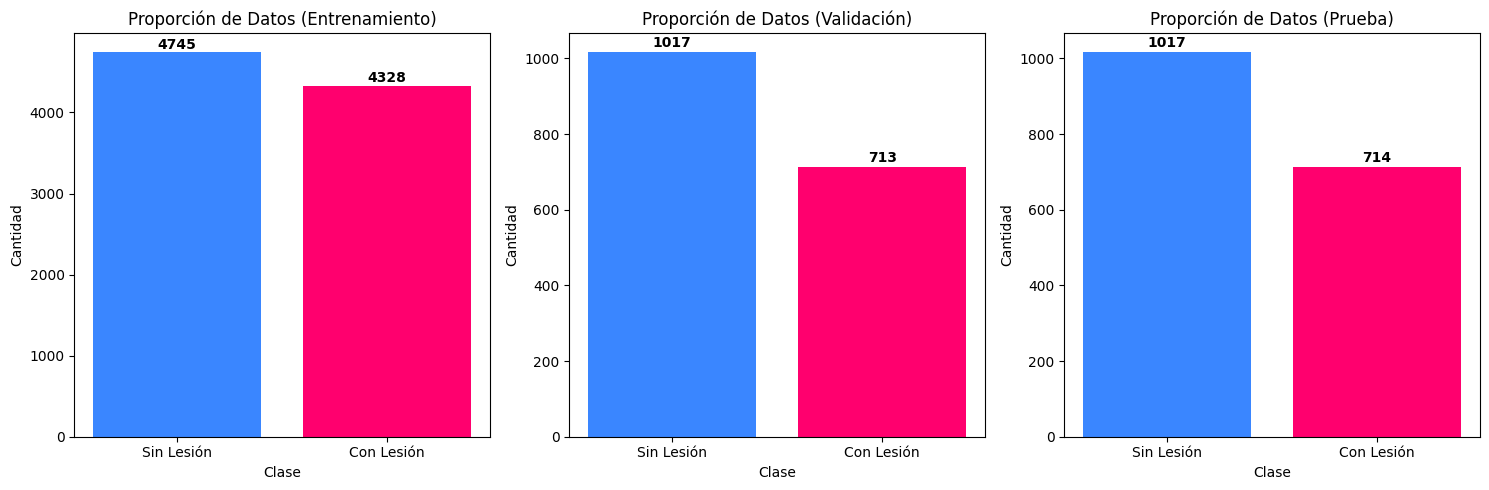

In [6]:
# Función para contar imágenes en las carpetas "lesion" y "no lesion"
def count_images_in_folders(folder_path):
    lesion_count = len(os.listdir(os.path.join(folder_path, '1_lesion')))
    no_lesion_count = len(os.listdir(os.path.join(folder_path, '0_no_lesion')))
    return lesion_count, no_lesion_count

# Función para crear gráficos de barras para las proporciones
def plot_proportion_subplot(ax, lesion_count, no_lesion_count, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_90x90_2clases/train'
val_dir = 'crops_90x90_2clases/val'
test_dir = 'crops_90x90_2clases/test'

# Contar las imágenes en cada conjunto
train_lesion_count, train_no_lesion_count = count_images_in_folders(train_dir)
val_lesion_count, val_no_lesion_count = count_images_in_folders(val_dir)
test_lesion_count, test_no_lesion_count = count_images_in_folders(test_dir)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_proportion_subplot(axes[0], train_lesion_count, train_no_lesion_count, 'Proporción de Datos (Entrenamiento)')
plot_proportion_subplot(axes[1], val_lesion_count, val_no_lesion_count, 'Proporción de Datos (Validación)')
plot_proportion_subplot(axes[2], test_lesion_count, test_no_lesion_count, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

#### Aumentación de Imagenes de la clase minoritaria

In [6]:
# Configuración del generador de imágenes con augmentation para la clase minoritaria
augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotaciones leves para preservar la estructura del núcleo
    horizontal_flip=True,   # Flip horizontal
    vertical_flip=True,     # Flip vertical
    brightness_range=[0.8, 1.2],  # Cambios en el brillo para simular variaciones de iluminación
    fill_mode='nearest'     # Relleno de los bordes tras los cambios de transformación
)

# Definir directorio de la clase con lesión
train_dir = 'crops_90x90_2clases/train/1_lesion'
output_dir = 'crops_90x90_2clases/train/1_lesion'  # Directorio para guardar imágenes augmentadas

# Crear la carpeta de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Cargar imágenes de la clase con lesión
lesion_generator = augmentation.flow_from_directory(
    'crops_90x90_2clases/train',  # Directorio raíz
    target_size=(90, 90),         # Tamaño de las imágenes
    batch_size=1,                 # Procesar una imagen por vez para guardarla
    class_mode='binary',
    classes=['1_lesion'],         # Solo tomar la clase con lesión
    shuffle=True
)

# Número de imágenes augmentadas que quieres generar
num_images_to_generate = 1000  # Cambia este valor según cuántas imágenes quieras generar

# Contador de imágenes generadas
generated_images = 0

# Generar y guardar imágenes augmentadas
for i in range(num_images_to_generate):
    if generated_images >= num_images_to_generate:
        break
    
    # Generar la imagen augmentada
    augmented_image = next(lesion_generator)[0]  # Primera imagen del batch
    
    # Eliminar la dimensión de batch
    augmented_image = np.squeeze(augmented_image, axis=0)
    
    # Convertir la imagen de nuevo a formato original (sin normalización)
    augmented_image = augmented_image * 255  # Deshacer el rescale aplicado por ImageDataGenerator
    img = array_to_img(augmented_image)  # Convertir a imagen PIL para guardar

    # Guardar la imagen augmentada
    img.save(os.path.join(output_dir, f'lesion_augmented_{generated_images}.png'))
    
    # Incrementar el contador
    generated_images += 1

print(f'{generated_images} imágenes augmentadas guardadas en {output_dir}')

Found 3328 images belonging to 1 classes.
1000 imágenes augmentadas guardadas en crops_90x90_2clases/train/1_lesion_augmented


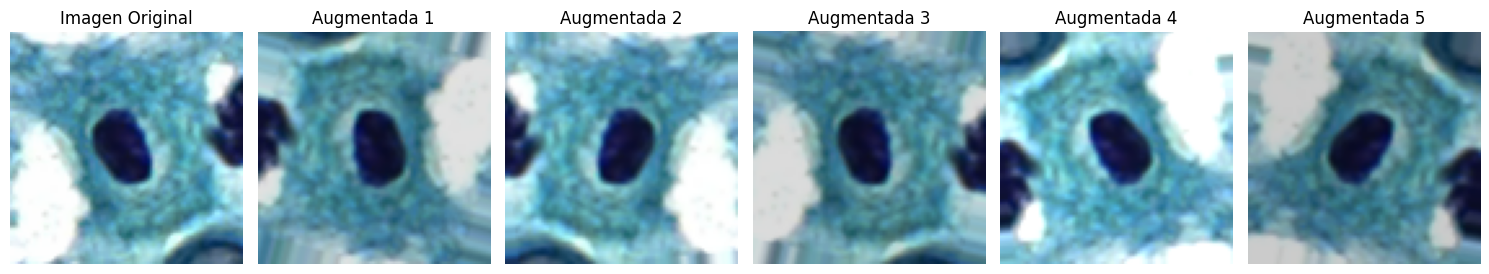

In [847]:
# Configuración del generador de imágenes con augmentation para la clase minoritaria
augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotaciones leves para preservar la estructura del núcleo
    horizontal_flip=True,   # Flip horizontal
    vertical_flip=True,     # Flip vertical
    brightness_range=[0.8, 1.2],  # Cambios en el brillo para simular variaciones de iluminación
    fill_mode='nearest'     # Relleno de los bordes tras los cambios de transformación
)

# Ruta de la carpeta con las imágenes originales (clase con lesión)
train_dir = 'crops_90x90_2clases/train/1_lesion'

# Cargar una imagen original para augmentación (cambia el nombre si es necesario)
img_path = os.path.join(train_dir, 'ee5338ab73b4db0c88f9e9dc98aca68e_LSIL_34.png')  # Cambia 'tu_imagen.jpg' por una imagen real en tu carpeta
original_image = load_img(img_path, target_size=(90, 90))  # Cargar la imagen original
original_image_array = img_to_array(original_image)  # Convertir la imagen a array

# Expande dimensiones para que coincida con el input del generador (batch size)
original_image_array = np.expand_dims(original_image_array, axis=0)

# Generador de imágenes augmentadas a partir de la imagen original
augment_generator = augmentation.flow(original_image_array, batch_size=1)

# Número de imágenes augmentadas a generar y mostrar
num_augmented_images = 5

# Visualizar la imagen original y 5 imágenes augmentadas
fig, ax = plt.subplots(1, num_augmented_images + 1, figsize=(15, 5))  # +1 para incluir la imagen original

# Mostrar la imagen original en el primer subplot
ax[0].imshow(original_image_array[0].astype('uint8'))
ax[0].set_title('Imagen Original')
ax[0].axis('off')

# Generar y mostrar las imágenes augmentadas
for i in range(1, num_augmented_images + 1):
    # Generar la imagen augmentada
    augmented_image = next(augment_generator)[0]  # Primera imagen del batch
    
    # Mostrar la imagen augmentada
    ax[i].imshow(augmented_image)
    ax[i].set_title(f'Augmentada {i}')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

#### Grafico con la distribución de las clases luego de la aumentación

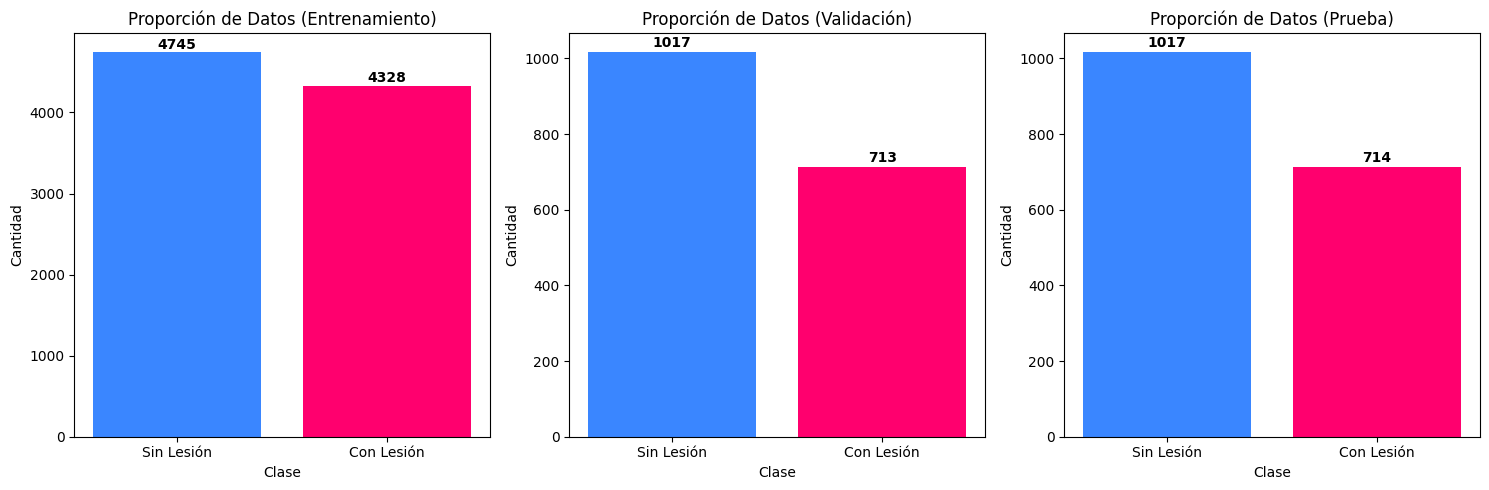

In [848]:
# Función para contar imágenes en las carpetas "lesion" y "no lesion"
def count_images_in_folders(folder_path):
    lesion_count = len(os.listdir(os.path.join(folder_path, '1_lesion')))
    no_lesion_count = len(os.listdir(os.path.join(folder_path, '0_no_lesion')))
    return lesion_count, no_lesion_count

# Función para crear gráficos de barras para las proporciones
def plot_proportion_subplot(ax, lesion_count, no_lesion_count, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_90x90_2clases/train'
val_dir = 'crops_90x90_2clases/val'
test_dir = 'crops_90x90_2clases/test'

# Contar las imágenes en cada conjunto
train_lesion_count, train_no_lesion_count = count_images_in_folders(train_dir)
val_lesion_count, val_no_lesion_count = count_images_in_folders(val_dir)
test_lesion_count, test_no_lesion_count = count_images_in_folders(test_dir)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_proportion_subplot(axes[0], train_lesion_count, train_no_lesion_count, 'Proporción de Datos (Entrenamiento)')
plot_proportion_subplot(axes[1], val_lesion_count, val_no_lesion_count, 'Proporción de Datos (Validación)')
plot_proportion_subplot(axes[2], test_lesion_count, test_no_lesion_count, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

#### Generación de los datos de entrenamiento, validación y test

In [7]:
# Directorios de las carpetas binarias
train_dir = 'crops_90x90_2clases/train'
val_dir = 'crops_90x90_2clases/val'
test_dir = 'crops_90x90_2clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde los directorios binarios para entrenamiento, validación y prueba
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(90, 90),  # Ajustar si necesitas cambiar el tamaño
    batch_size=32,
    class_mode='binary',  # Clasificación binaria
    shuffle=True 
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Asegurar que el orden sea consistente
)


Found 9073 images belonging to 2 classes.
Found 1730 images belonging to 2 classes.
Found 1731 images belonging to 2 classes.


### MovileNetV2

In [37]:
# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), f1_score])  #tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
284/284 [==============================] - 20s 64ms/step - loss: 0.4499 - accuracy: 0.7889 - precision: 0.7696 - recall: 0.7957 - auc: 0.8741 - f1_score: 0.6459 - val_loss: 0.7335 - val_accuracy: 0.7474 - val_precision: 0.9286 - val_recall: 0.4194 - val_auc: 0.8941 - val_f1_score: 0.5837
Epoch 2/30
284/284 [==============================] - 17s 60ms/step - loss: 0.2712 - accuracy: 0.8861 - precision: 0.8750 - recall: 0.8882 - auc: 0.9550 - f1_score: 0.6459 - val_loss: 0.4871 - val_accuracy: 0.8087 - val_precision: 0.9099 - val_recall: 0.5947 - val_auc: 0.9204 - val_f1_score: 0.5837
Epoch 3/30
284/284 [==============================] - 17s 61ms/step - loss: 0.1807 - accuracy: 0.9268 - precision: 0.9204 - recall: 0.9268 - auc: 0.9805 - f1_score: 0.6460 - val_loss: 0.7045 - val_accuracy: 0.7763 - val_precision: 0.9503 - val_recall: 0.4825 - val_auc: 0.9234 - val_f1_score: 0.5842
Epoch 4/30
284/284 [==============================] - 18s 64ms/step - loss: 0.1320 - accuracy: 0.946

InvalidArgumentError: Graph execution error:

'dim' must be a tensor with a single value
	 [[{{node ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_bool_ExpandDims}}]] [Op:__inference_test_function_300881]

#### Evaluación

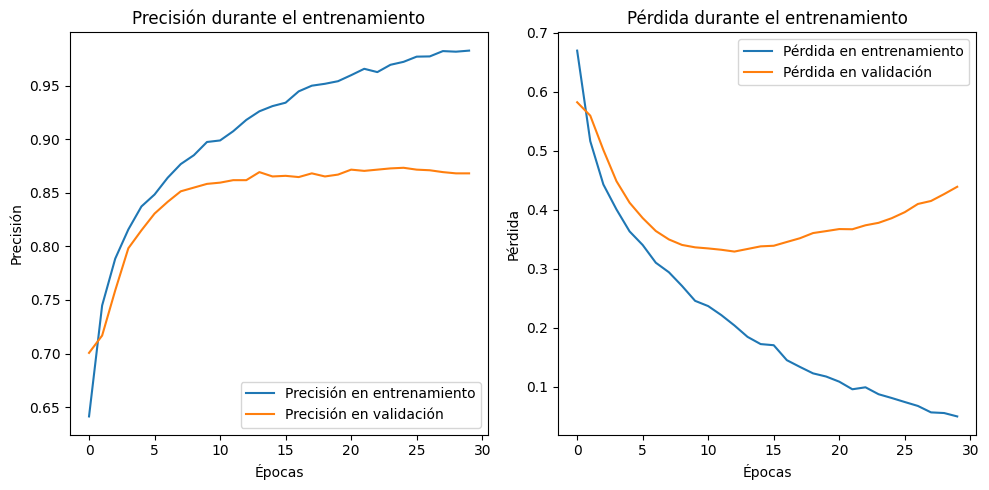

In [28]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

# 55/55 [==============================] - 2s 29ms/step - loss: 0.3659 - accuracy: 0.8758 - precision: 0.8675 - recall: 0.8249 - auc: 0.9414 - f1_score: 0.5840
# Pérdida en el conjunto de prueba: 0.36590656638145447
# accuracy en el conjunto de prueba: 0.8757943511009216
# Precision en el conjunto de prueba: 0.8674521446228027
# Recall en el conjunto de prueba: 0.82492995262146
# AUC en el conjunto de prueba: 0.9414162039756775
# F1-Score en el conjunto de prueba: [0.58404905]

55/55 [==============================] - 2s 36ms/step - loss: 0.4060 - accuracy: 0.8798 - precision: 0.8929 - recall: 0.8053 - auc: 0.9379 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.40602320432662964
accuracy en el conjunto de prueba: 0.879838228225708
Precision en el conjunto de prueba: 0.8928571343421936
Recall en el conjunto de prueba: 0.8053221106529236
AUC en el conjunto de prueba: 0.9378726482391357
F1-Score en el conjunto de prueba: [0.58404905]


**Matriz de confusión**

55/55 [==============================] - 2s 34ms/step


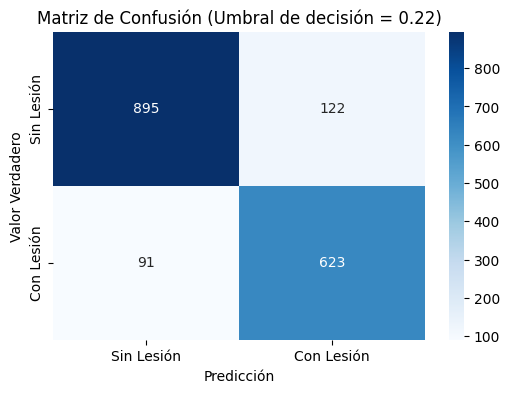

Recall (con umbral = 0.22): 0.8725490196078431
Precisión (con umbral = 0.22): 0.836241610738255


In [36]:
# Definir el nuevo umbral de decisión
threshold = 0.22  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 2s 35ms/step


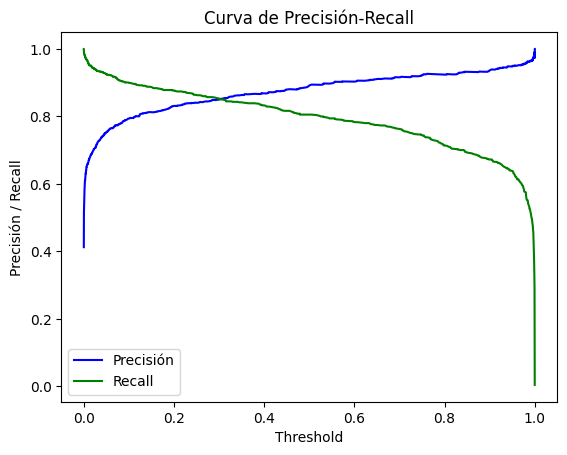

In [31]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

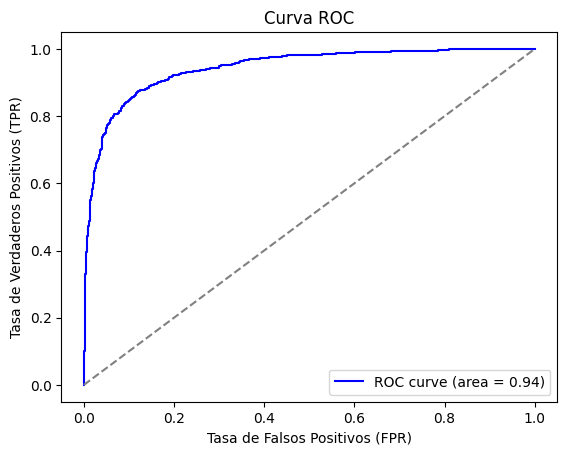

In [32]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [35]:
# Ajustar el umbral de decisión
new_threshold = 0.22
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.7435897435897436
Recall: 0.9341736694677871
F1-Score: 0.8280571073867162
AUC: 0.945376774111808


In [34]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 2s 36ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.22
Mejor F1-score: 0.8540095956134339


### MobileNetV3

In [945]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-4),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
284/284 [==============================] - 13s 28ms/step - loss: 0.6223 - accuracy: 0.6533 - precision: 0.6389 - recall: 0.6282 - auc: 0.7132 - f1_score: 0.6459 - val_loss: 0.6905 - val_accuracy: 0.5861 - val_precision: 0.4800 - val_recall: 0.0505 - val_auc: 0.5598 - val_f1_score: 0.5837
Epoch 2/30
284/284 [==============================] - 7s 23ms/step - loss: 0.5517 - accuracy: 0.7225 - precision: 0.7021 - recall: 0.7264 - auc: 0.7941 - f1_score: 0.6459 - val_loss: 0.6916 - val_accuracy: 0.5821 - val_precision: 0.3810 - val_recall: 0.0224 - val_auc: 0.4239 - val_f1_score: 0.5837
Epoch 3/30
284/284 [==============================] - 7s 24ms/step - loss: 0.5163 - accuracy: 0.7542 - precision: 0.7327 - recall: 0.7632 - auc: 0.8245 - f1_score: 0.6459 - val_loss: 0.6931 - val_accuracy: 0.5289 - val_precision: 0.3658 - val_recall: 0.1950 - val_auc: 0.4448 - val_f1_score: 0.5837
Epoch 4/30
284/284 [==============================] - 7s 23ms/step - loss: 0.5022 - accuracy: 0.7614 -

#### Evaluación

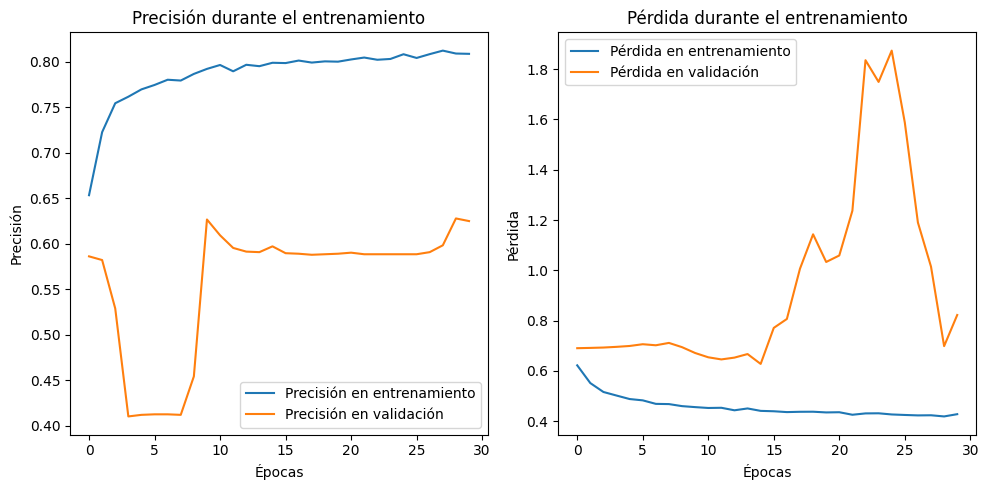

In [946]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [947]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 1s 23ms/step - loss: 0.8213 - accuracy: 0.6320 - precision: 0.9326 - recall: 0.1162 - auc: 0.8956 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.821283221244812
accuracy en el conjunto de prueba: 0.6320046186447144
Precision en el conjunto de prueba: 0.932584285736084
Recall en el conjunto de prueba: 0.11624649912118912
AUC en el conjunto de prueba: 0.8955858945846558
F1-Score en el conjunto de prueba: [0.58404905]


**Matriz de confusión**

55/55 [==============================] - 1s 23ms/step


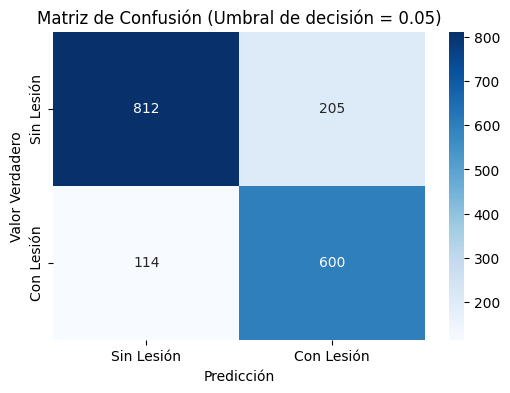

Recall (con umbral = 0.05): 0.8403361344537815
Precisión (con umbral = 0.05): 0.7453416149068323


In [953]:
# Definir el nuevo umbral de decisión
threshold = 0.05  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 1s 19ms/step


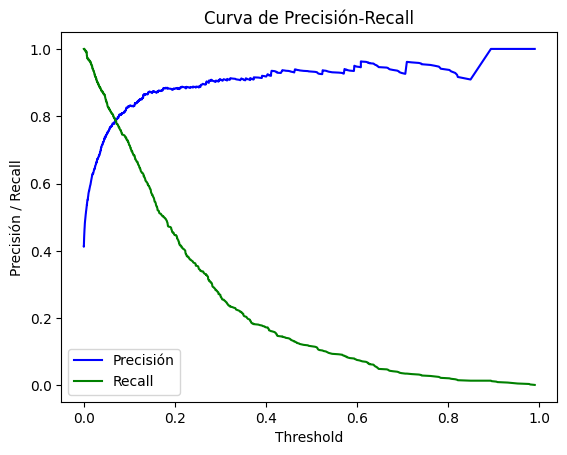

In [949]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

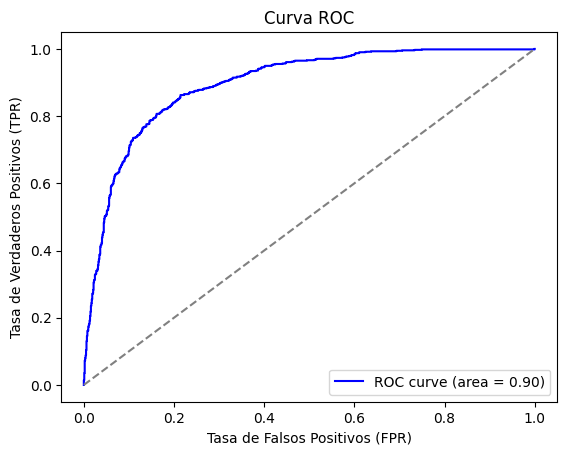

In [950]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [951]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.5696619950535862
Recall: 0.9677871148459384
F1-Score: 0.7171769590036325
AUC: 0.8900883854033256


In [952]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 1s 20ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.05
Mejor F1-score: 0.7899934167215273


### EfficientNetB0

In [ ]:
# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Cambiar para descongelar solo las últimas 10 capas
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
    class_weight={0: 1., 1: 3.0}  # Ajustar class_weight para clases desbalanceadas
)

Epoch 1/30
253/253 [==============================] - 22s 77ms/step - loss: 1.3357 - accuracy: 0.4252 - precision: 0.4123 - recall: 0.9261 - auc: 0.5103 - f1_score: 0.5103 - val_loss: 0.8476 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.4950 - val_f1_score: 0.4950 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 18s 71ms/step - loss: 1.2852 - accuracy: 0.4146 - precision: 0.4109 - recall: 0.9684 - auc: 0.5287 - f1_score: 0.5287 - val_loss: 0.8796 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7397 - val_f1_score: 0.7397 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 18s 72ms/step - loss: 1.2630 - accuracy: 0.4219 - precision: 0.4147 - recall: 0.9775 - auc: 0.5591 - f1_score: 0.5591 - val_loss: 0.8501 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7839 - val_f1_score: 0.7839 - lr: 1.0000e-04
Epoch 4/30
253/253 [=============================

#### Evaluación

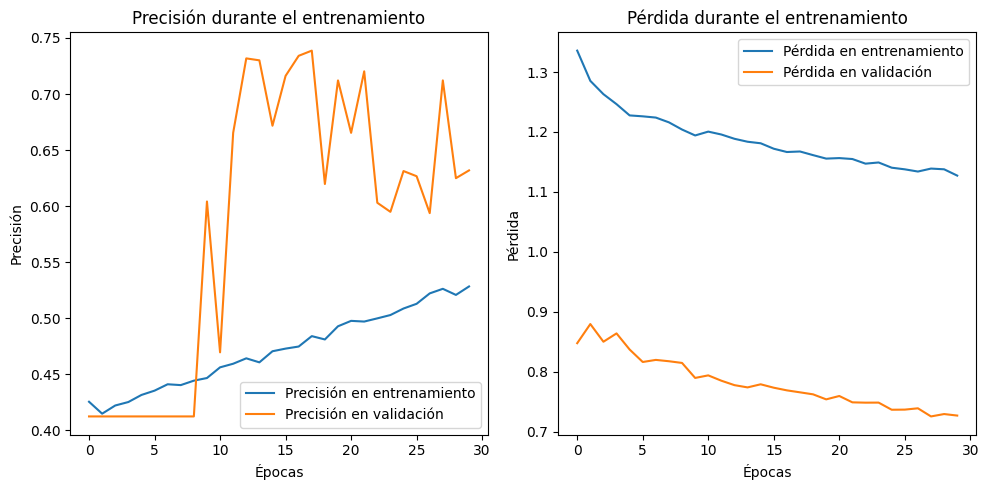

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 3s 58ms/step - loss: 0.7291 - accuracy: 0.6424 - precision: 0.8369 - recall: 0.1653 - auc: 0.7936 - f1_score: 0.7936
Pérdida en el conjunto de prueba: 0.7291462421417236
accuracy en el conjunto de prueba: 0.642403244972229
Precision en el conjunto de prueba: 0.8368794322013855
Recall en el conjunto de prueba: 0.16526611149311066
AUC en el conjunto de prueba: 0.7935826182365417
F1-Score en el conjunto de prueba: 0.7935826182365417


**Matriz de confusión**

55/55 [==============================] - 3s 57ms/step


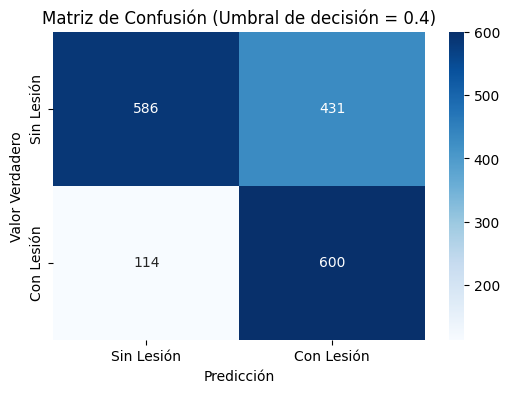

Recall (con umbral = 0.4): 0.8403361344537815
Precisión (con umbral = 0.4): 0.5819592628516004


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.4  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 3s 57ms/step


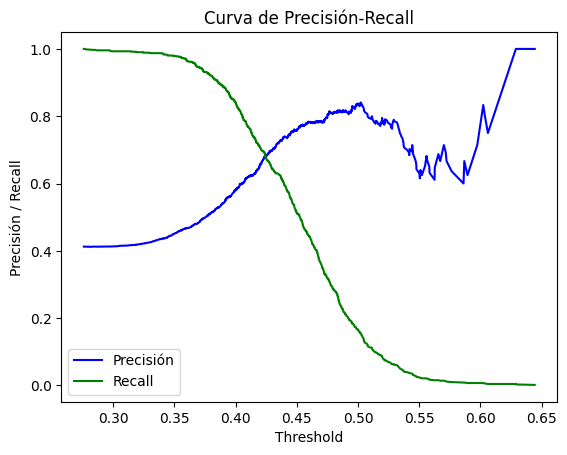

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

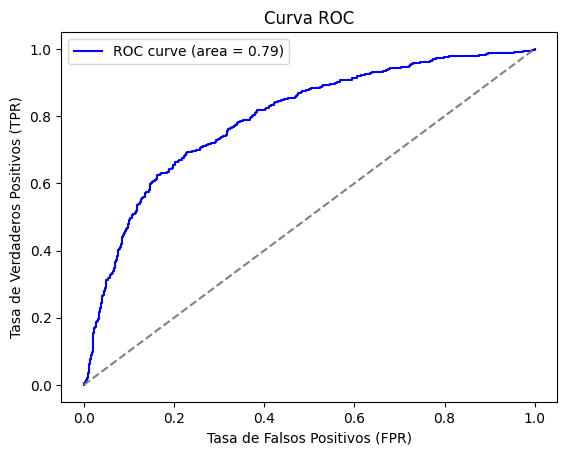

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 3s 60ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.4
Mejor F1-score: 0.6876790830945558


### ResNet

In [785]:
# Cargar ResNet50 preentrenado en ImageNet, sin la capa superior
base_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Incrementar el dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar algunas capas del modelo base para ajustar los pesos
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Ajusta el número de capas descongeladas si es necesario
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Aplicar class_weight para manejar el desbalanceo de clases
class_weight = {0: 1., 1: 3.5}  # Dar más peso a la clase con "lesión"

history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30
253/253 [==============================] - 84s 325ms/step - loss: 0.4925 - accuracy: 0.7551 - precision: 0.7075 - recall: 0.6920 - auc: 0.8330 - f1_score: 0.5838 - val_loss: 0.6210 - val_accuracy: 0.6387 - val_precision: 0.5357 - val_recall: 0.9257 - val_auc: 0.8280 - val_f1_score: 0.5837
Epoch 2/30
253/253 [==============================] - 81s 321ms/step - loss: 0.4327 - accuracy: 0.7983 - precision: 0.7549 - recall: 0.7563 - auc: 0.8765 - f1_score: 0.5838 - val_loss: 0.4052 - val_accuracy: 0.8197 - val_precision: 0.8463 - val_recall: 0.6872 - val_auc: 0.9006 - val_f1_score: 0.5837
Epoch 3/30
253/253 [==============================] - 88s 349ms/step - loss: 0.4170 - accuracy: 0.8117 - precision: 0.7739 - recall: 0.7674 - auc: 0.8859 - f1_score: 0.5838 - val_loss: 0.4363 - val_accuracy: 0.7931 - val_precision: 0.8884 - val_recall: 0.5694 - val_auc: 0.9034 - val_f1_score: 0.5837
Epoch 4/30
253/253 [==============================] - 83s 330ms/step - loss: 0.4051 - accuracy: 0

#### Evaluación

In [787]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 8s 150ms/step - loss: 0.5589 - accuracy: 0.7880 - precision: 0.8505 - recall: 0.5896 - auc: 0.8801 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.5589182376861572
accuracy en el conjunto de prueba: 0.7879838347434998
Precision en el conjunto de prueba: 0.8505050539970398
Recall en el conjunto de prueba: 0.5896358489990234
AUC en el conjunto de prueba: 0.8801308870315552
F1-Score en el conjunto de prueba: [0.58404905]


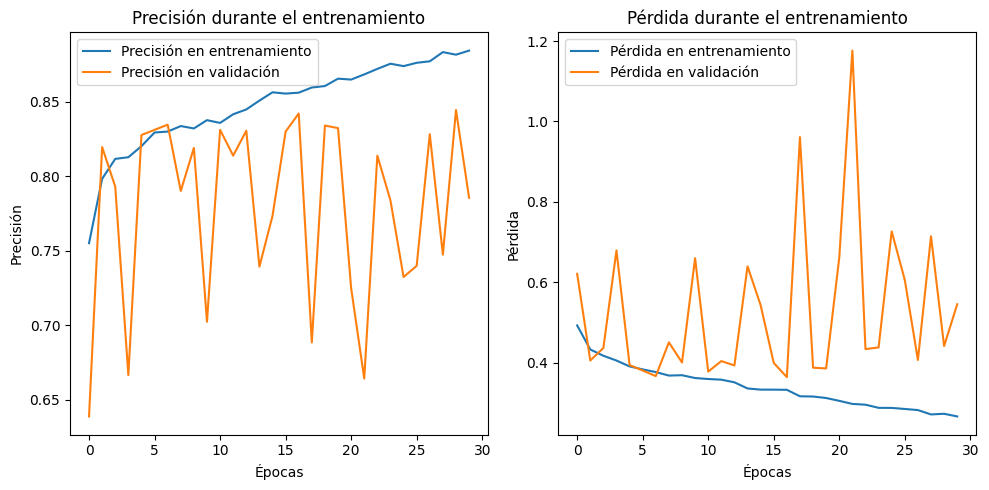

In [788]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Matriz de confusión**

55/55 [==============================] - 9s 160ms/step


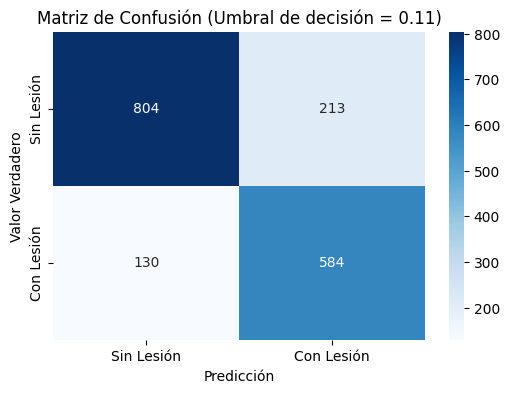

Recall (con umbral = 0.11): 0.8179271708683473
Precisión (con umbral = 0.11): 0.7327478042659975


In [793]:
# Definir el nuevo umbral de decisión
threshold = 0.11  # Ajusta este valor (ej. 0.3) para mejorar el recall

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegurar que y_true tenga el mismo tamaño que y_pred

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 8s 152ms/step


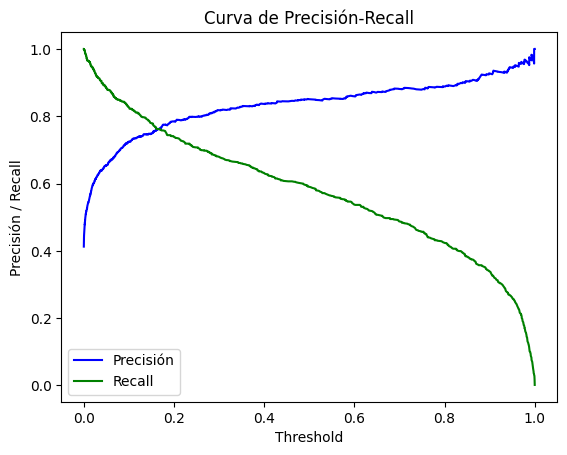

In [790]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

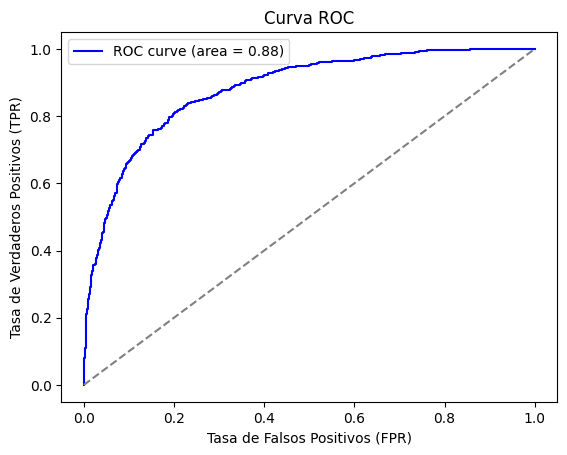

In [791]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [792]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

55/55 [==============================] - 9s 170ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.11
Mejor F1-score: 0.7729980145598941


### EfficientNetB0

In [823]:
# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Cambiar para descongelar solo las últimas 10 capas
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
    class_weight={0: 1., 1: 3.0}  # Ajustar class_weight para clases desbalanceadas
)

Epoch 1/30
253/253 [==============================] - 22s 77ms/step - loss: 1.3357 - accuracy: 0.4252 - precision: 0.4123 - recall: 0.9261 - auc: 0.5103 - f1_score: 0.5103 - val_loss: 0.8476 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.4950 - val_f1_score: 0.4950 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 18s 71ms/step - loss: 1.2852 - accuracy: 0.4146 - precision: 0.4109 - recall: 0.9684 - auc: 0.5287 - f1_score: 0.5287 - val_loss: 0.8796 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7397 - val_f1_score: 0.7397 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 18s 72ms/step - loss: 1.2630 - accuracy: 0.4219 - precision: 0.4147 - recall: 0.9775 - auc: 0.5591 - f1_score: 0.5591 - val_loss: 0.8501 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7839 - val_f1_score: 0.7839 - lr: 1.0000e-04
Epoch 4/30
253/253 [=============================

#### Evaluación

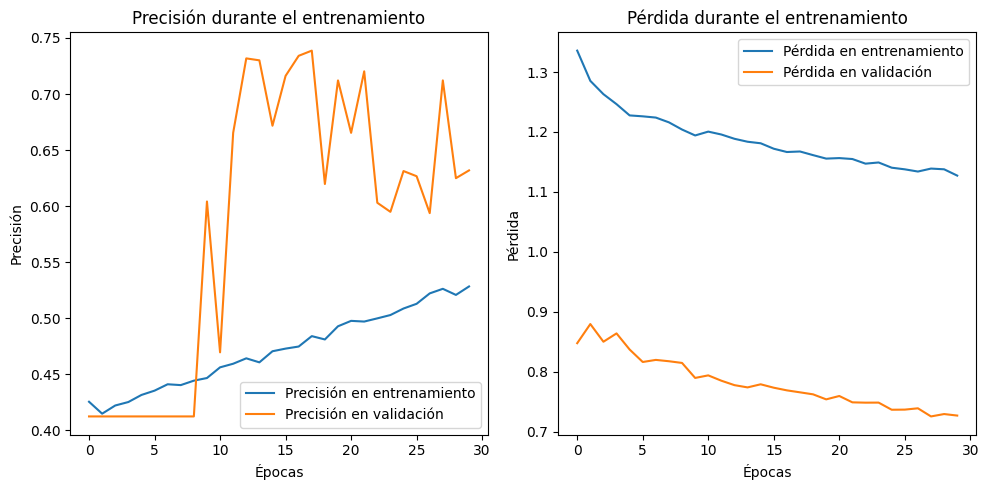

In [824]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [825]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 3s 58ms/step - loss: 0.7291 - accuracy: 0.6424 - precision: 0.8369 - recall: 0.1653 - auc: 0.7936 - f1_score: 0.7936
Pérdida en el conjunto de prueba: 0.7291462421417236
accuracy en el conjunto de prueba: 0.642403244972229
Precision en el conjunto de prueba: 0.8368794322013855
Recall en el conjunto de prueba: 0.16526611149311066
AUC en el conjunto de prueba: 0.7935826182365417
F1-Score en el conjunto de prueba: 0.7935826182365417


**Matriz de confusión**

55/55 [==============================] - 3s 57ms/step


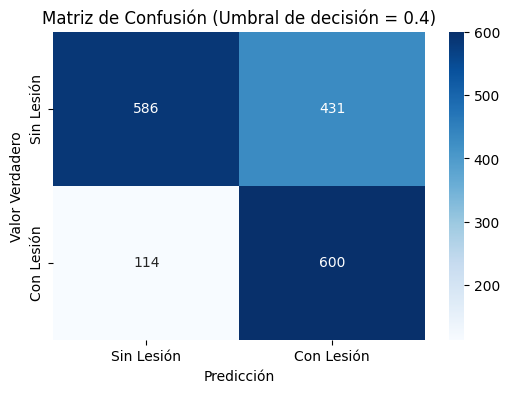

Recall (con umbral = 0.4): 0.8403361344537815
Precisión (con umbral = 0.4): 0.5819592628516004


In [834]:
# Definir el nuevo umbral de decisión
threshold = 0.4  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 3s 57ms/step


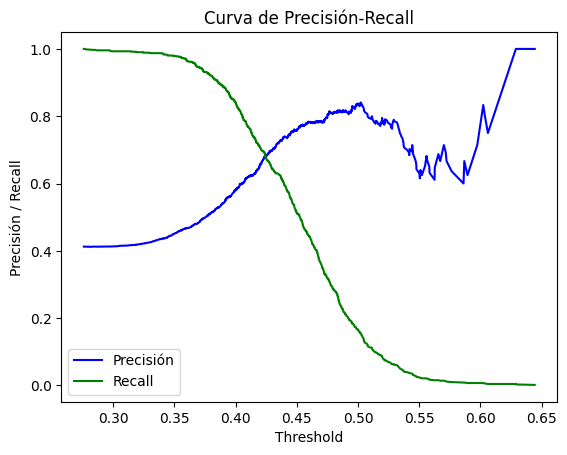

In [827]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

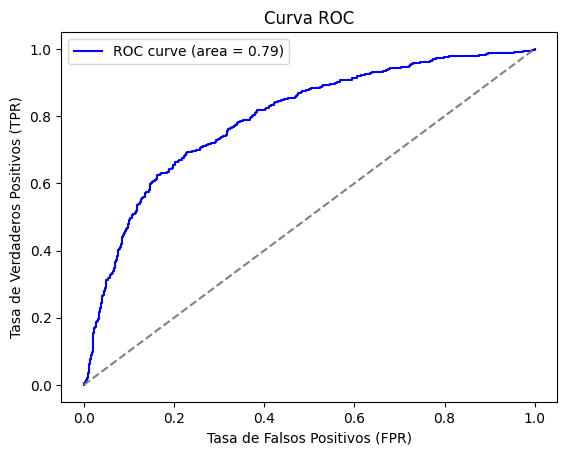

In [828]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [833]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [831]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 3s 60ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.4
Mejor F1-score: 0.6876790830945558


### EfficientNetB6

In [865]:
# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB6(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Cambiar para descongelar solo las últimas 10 capas
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau 
)

165234480/165234480 [==============================] - 12s 0us/step
Epoch 1/30
284/284 [==============================] - 99s 315ms/step - loss: 0.8230 - accuracy: 0.5123 - precision: 0.4868 - recall: 0.4147 - auc: 0.5146 - f1_score: 0.5146 - val_loss: 0.8199 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.5717 - val_f1_score: 0.5717 - lr: 1.0000e-04
Epoch 2/30
284/284 [==============================] - 83s 293ms/step - loss: 0.7980 - accuracy: 0.5240 - precision: 0.5015 - recall: 0.3533 - auc: 0.5267 - f1_score: 0.5267 - val_loss: 0.7774 - val_accuracy: 0.6133 - val_precision: 0.5733 - val_recall: 0.2412 - val_auc: 0.6080 - val_f1_score: 0.6080 - lr: 1.0000e-04
Epoch 3/30
284/284 [==============================] - 84s 297ms/step - loss: 0.7825 - accuracy: 0.5423 - precision: 0.5301 - recall: 0.3563 - auc: 0.5473 - f1_score: 0.5473 - val_loss: 0.7669 - val_accuracy: 0.6075 - val_precision: 0.6062 - val_recall: 0.1360 - val_auc: 0.6172 - val_f1_score: 0.

#### Evaluación

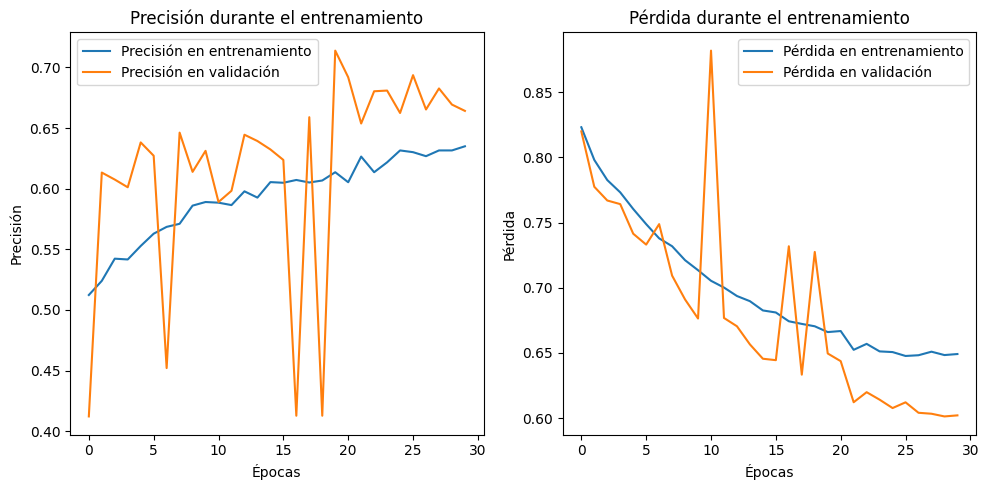

In [866]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [867]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 14s 260ms/step - loss: 0.5962 - accuracy: 0.6742 - precision: 0.7206 - recall: 0.3431 - auc: 0.7889 - f1_score: 0.7889
Pérdida en el conjunto de prueba: 0.5962381362915039
accuracy en el conjunto de prueba: 0.6741767525672913
Precision en el conjunto de prueba: 0.720588207244873
Recall en el conjunto de prueba: 0.343137264251709
AUC en el conjunto de prueba: 0.7889147996902466
F1-Score en el conjunto de prueba: 0.7889147996902466


**Matriz de confusión**

55/55 [==============================] - 13s 227ms/step


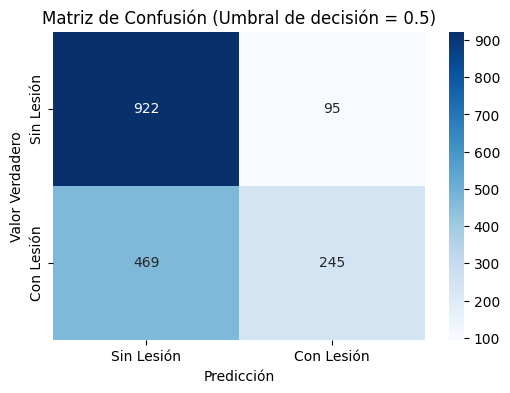

Recall (con umbral = 0.5): 0.3431372549019608
Precisión (con umbral = 0.5): 0.7205882352941176


In [873]:
# Definir el nuevo umbral de decisión
threshold = 0.5  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 13s 238ms/step


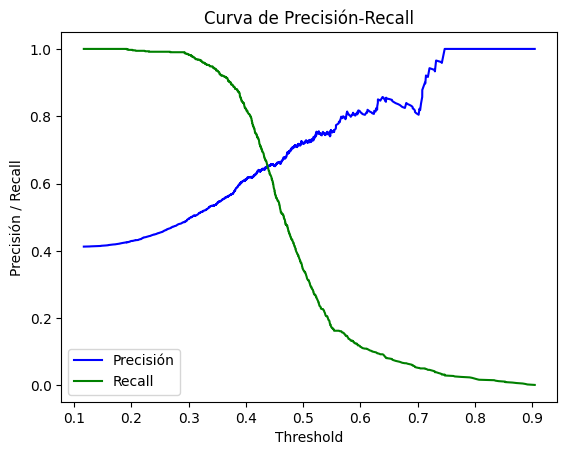

In [869]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

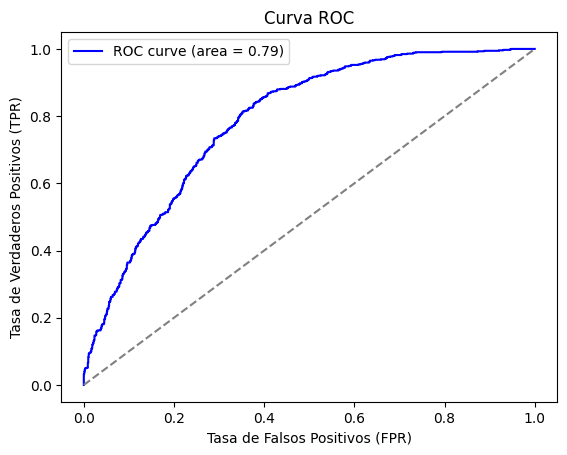

In [870]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [871]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [872]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 13s 239ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.39
Mejor F1-score: 0.7050691244239632


# Clasificación Binaria prueba en w&b

In [10]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-2Clases', entity='tp3-td6', name='MobileNetV2')

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.3),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 30 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compilar el modelo con métricas adicionales
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/30
284/284 [==============================] - 22s 72ms/step - loss: 0.6745 - accuracy: 0.6271 - precision: 0.6386 - recall: 0.5030 - auc: 0.6907 - val_loss: 0.6058 - val_accuracy: 0.6965 - val_precision: 0.7597 - val_recall: 0.3857 - val_auc: 0.7985 - lr: 1.0000e-05
Epoch 2/30
284/284 [==============================] - 20s 70ms/step - loss: 0.5108 - accuracy: 0.7423 - precision: 0.7316 - recall: 0.7262 - auc: 0.8275 - val_loss: 0.5377 - val_accuracy: 0.7289 - val_precision: 0.8065 - val_recall: 0.4502 - val_auc: 0.8559 - lr: 1.0000e-05
Epoch 3/30
284/284 [==============================] - 21s 74ms/step - loss: 0.4457 - accuracy: 0.7885 - precision: 0.7713 - recall: 0.7911 - auc: 0.8725 - val_loss: 0.4779 - val_accuracy: 0.7671 - val_precision: 0.8243 - val_recall: 0.5526 - val_auc: 0.8793 - lr: 1.0000e-05
Epoch 4/30
284/284 [==============================] - 22s 77ms/step - loss: 0.3928 - accuracy: 0.8235 - precision: 0.8067 - recall: 0.8286 - auc: 0.9030 - val_loss: 0.4438 - v

ValueError: too many values to unpack (expected 2)

55/55 [==============================] - 2s 43ms/step - loss: 0.2986 - accuracy: 0.8804 - precision: 0.8545 - recall: 0.8557 - auc: 0.9452
Precisión en el conjunto de prueba: 0.8804
Recall en el conjunto de prueba: 0.8557
Precision en el conjunto de prueba: 0.8545
AUC en el conjunto de prueba: 0.9452
55/55 [==============================] - 3s 44ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1017
           1       0.85      0.86      0.86       714

    accuracy                           0.88      1731
   macro avg       0.88      0.88      0.88      1731
weighted avg       0.88      0.88      0.88      1731



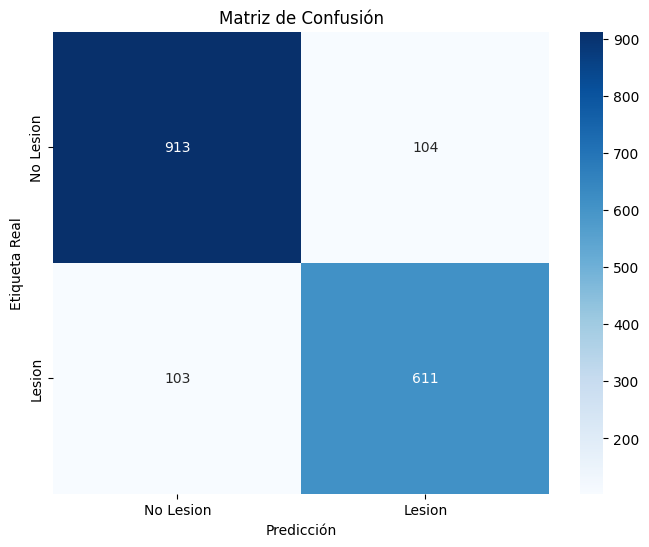

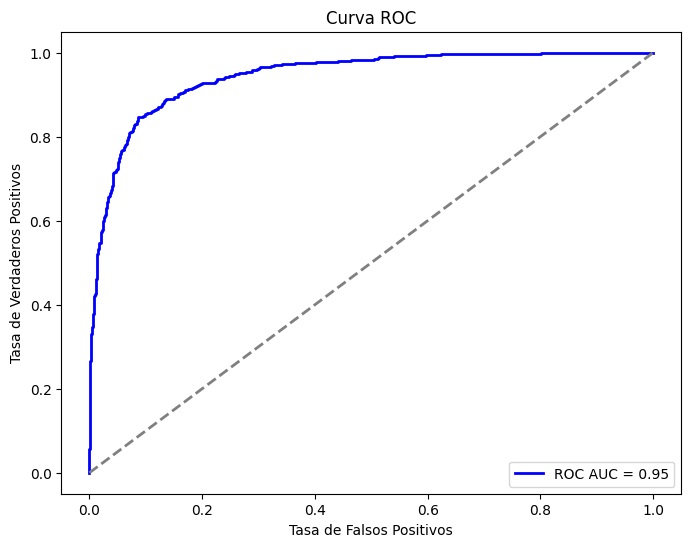

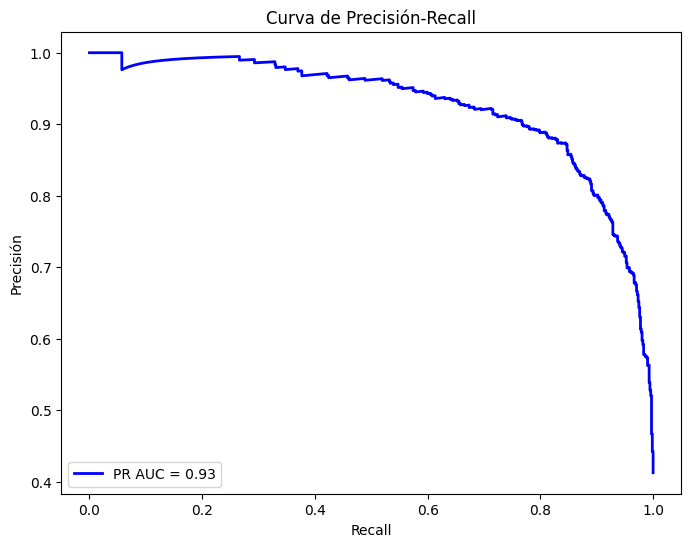

pr_auc,▁
roc_auc,▁
test_accuracy,▁
test_loss,▁
pr_auc,0.92586
roc_auc,0.94538
test_accuracy,0.88042
test_loss,0.29856


In [11]:
# Evaluar el modelo en el conjunto de prueba
evaluation_metrics = model.evaluate(test_generator)

# Asumiendo que tienes 5 métricas (loss, accuracy, precision, recall, auc)
test_loss, test_acc, test_precision, test_recall, test_auc = evaluation_metrics
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"AUC en el conjunto de prueba: {test_auc:.4f}")

# Generar predicciones y etiquetas verdaderas
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Reporte de clasificación
print(classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

# Curva de precisión y recall
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR AUC = {pr_auc:.2f}')
plt.title('Curva de Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.legend(loc='lower left')
plt.show()

# Loggear manualmente las métricas en W&B
wandb.log({
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'confusion_matrix': wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=y_pred, class_names=['No Lesion', 'Lesion']),
})

# Terminar la ejecución de W&B
wandb.finish()

# clasificación binaria con cross validation

In [46]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers.legacy import Adam

# Directorio de las imágenes
data_dir = 'crops_90x90'

# Crear generadores de imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar todas las imágenes y etiquetas
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    classes=['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC'],
    shuffle=False
)

# Obtener los nombres de archivos y etiquetas
filepaths = all_images_generator.filepaths
labels = all_images_generator.classes

# Convertir las etiquetas multiclase en binarias basado en el índice de 'Negative'
negative_index = all_images_generator.class_indices['Negative']
has_lesion = np.where(labels == negative_index, 0, 1)  # 0: Negative (sin lesión), 1: Otras clases (con lesión)

# Crear dataframe con los archivos y etiquetas binarizadas
df = pd.DataFrame({'filepath': filepaths, 'has_lesion': has_lesion})

# Separar un 20% de los datos como conjunto de prueba final
train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    df['filepath'], df['has_lesion'], test_size=0.2, stratify=df['has_lesion'], random_state=42
)

# Configuración para el cross-validation (5 folds) con el 80% restante
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Función para copiar imágenes a los directorios temporales
def copy_images(filepaths, lesions, dest_dir):
    for filepath, lesion in zip(filepaths, lesions):
        if lesion == 0:  # Sin lesión (Negative)
            dest_subfolder = '0_no_lesion'
        else:  # Con lesión
            dest_subfolder = '1_lesion'
        dest_path = os.path.join(dest_dir, dest_subfolder)
        shutil.copy(filepath, dest_path)

# Directorio de salida para las imágenes de cada fold
output_dir = 'crops_90x90_2clases_5folds'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Crear las carpetas si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Subcarpetas para lesion/no lesion
lesion_subfolders = ['1_lesion', '0_no_lesion']
for subfolder in lesion_subfolders:
    os.makedirs(os.path.join(train_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subfolder), exist_ok=True)

# Copiar las imágenes del conjunto de prueba final
copy_images(test_files, test_labels, test_dir)

# Proceso K-Fold
fold_num = 1
for train_index, val_index in kf.split(train_val_files):
    print(f"Fold {fold_num}")
    
    # Dividir los datos en entrenamiento y validación
    train_files = train_val_files.iloc[train_index]
    train_lesion = train_val_labels.iloc[train_index]
    val_files = train_val_files.iloc[val_index]
    val_lesion = train_val_labels.iloc[val_index]

    # Copiar las imágenes a los directorios correspondientes
    copy_images(train_files, train_lesion, train_dir)
    copy_images(val_files, val_lesion, val_dir)

    # Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
    base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    # Crear el modelo final
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(54, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')  # Clasificación binaria
    ])

    # Descongelar las últimas 30 capas del modelo base
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Compilar el modelo con métricas adicionales
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    # Crear los generadores de datos
    train_generator = datagen.flow_from_directory(train_dir, target_size=(90, 90), batch_size=32, class_mode='binary')
    val_generator = datagen.flow_from_directory(val_dir, target_size=(90, 90), batch_size=32, class_mode='binary')

    # Entrenar el modelo
    history = model.fit(
        train_generator,
        epochs=30,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    # Limpiar el directorio de imágenes para el siguiente fold
    shutil.rmtree(train_dir)
    shutil.rmtree(val_dir)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    for subfolder in lesion_subfolders:
        os.makedirs(os.path.join(train_dir, subfolder), exist_ok=True)
        os.makedirs(os.path.join(val_dir, subfolder), exist_ok=True)

    # Aumentar contador de fold
    fold_num += 1

print("Cross-validation completada.")

# Evaluación final en el conjunto de prueba reservado
test_generator = datagen.flow_from_directory(test_dir, target_size=(96, 96), batch_size=32, class_mode='binary', shuffle=False)

test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Exactitud en el conjunto de prueba: {test_acc}")
print(f"Precisión en el conjunto de prueba: {test_precision}")
print(f"Recall en el conjunto de prueba: {test_recall}")
print(f"AUC en el conjunto de prueba: {test_auc}")

Found 11534 images belonging to 6 classes.
Fold 1
Found 7381 images belonging to 2 classes.
Found 1846 images belonging to 2 classes.
Epoch 1/30
231/231 [==============================] - 14s 52ms/step - loss: 0.7158 - accuracy: 0.6135 - precision: 0.5315 - recall: 0.5082 - auc: 0.6480 - val_loss: 0.6246 - val_accuracy: 0.6896 - val_precision: 0.7181 - val_recall: 0.4180 - val_auc: 0.7958 - lr: 1.0000e-05
Epoch 2/30
231/231 [==============================] - 11s 49ms/step - loss: 0.5592 - accuracy: 0.7098 - precision: 0.6537 - recall: 0.6262 - auc: 0.7833 - val_loss: 0.6130 - val_accuracy: 0.7037 - val_precision: 0.7769 - val_recall: 0.4036 - val_auc: 0.8317 - lr: 1.0000e-05
Epoch 3/30
231/231 [==============================] - 11s 48ms/step - loss: 0.4993 - accuracy: 0.7590 - precision: 0.7113 - recall: 0.6970 - auc: 0.8331 - val_loss: 0.5641 - val_accuracy: 0.7297 - val_precision: 0.8135 - val_recall: 0.4544 - val_auc: 0.8564 - lr: 1.0000e-05
Epoch 4/30
231/231 [=====================

73/73 [==============================] - 3s 39ms/step - loss: 0.3013 - accuracy: 0.8782 - precision: 0.8790 - recall: 0.8170 - auc: 0.9451
Precisión en el conjunto de prueba: 0.8782
Recall en el conjunto de prueba: 0.8170
Precision en el conjunto de prueba: 0.8790
AUC en el conjunto de prueba: 0.9451
73/73 [==============================] - 3s 37ms/step
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1356
           1       0.88      0.82      0.85       951

    accuracy                           0.88      2307
   macro avg       0.88      0.87      0.87      2307
weighted avg       0.88      0.88      0.88      2307



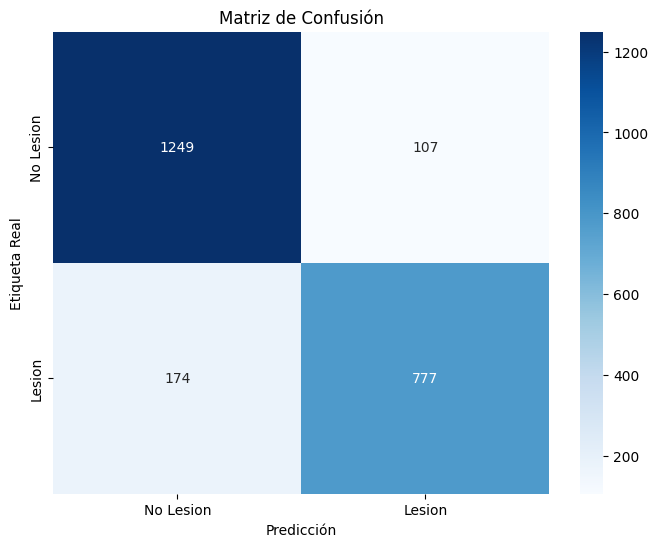

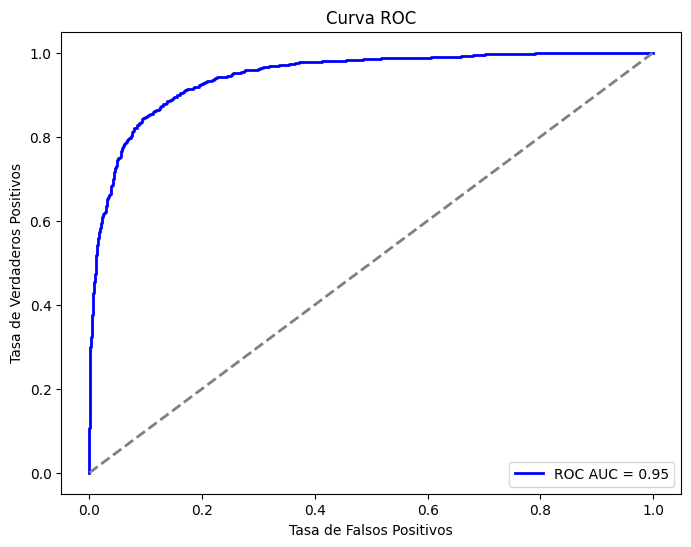

In [45]:
# Evaluar el modelo en el conjunto de prueba
evaluation_metrics = model.evaluate(test_generator)

# Asumiendo que tienes 5 métricas (loss, accuracy, precision, recall, auc)
test_loss, test_acc, test_precision, test_recall, test_auc = evaluation_metrics
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"AUC en el conjunto de prueba: {test_auc:.4f}")

# Generar predicciones y etiquetas verdaderas
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Reporte de clasificación
print(classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

In [43]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

73/73 [==============================] - 2s 34ms/step
Dimensiones de y_pred_proba: (2307, 1)
Dimensiones de y_true: (2307,)
Mejor threshold para F1-score: 0.43
Mejor F1-score: 0.8522848034006376


73/73 [==============================] - 3s 35ms/step


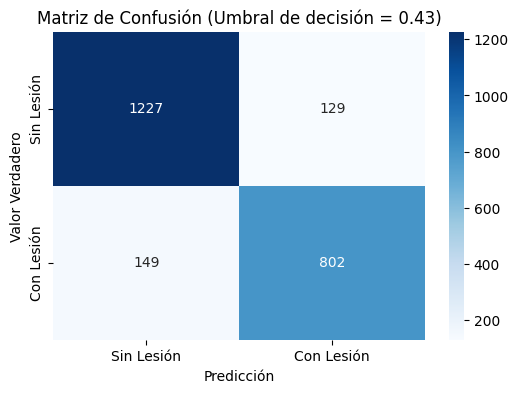

Recall (con umbral = 0.43): 0.843322818086225
Precisión (con umbral = 0.43): 0.8614393125671321


In [44]:
# Definir el nuevo umbral de decisión
threshold = 0.43  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')